# Korean Englishman - Youtube Analytics

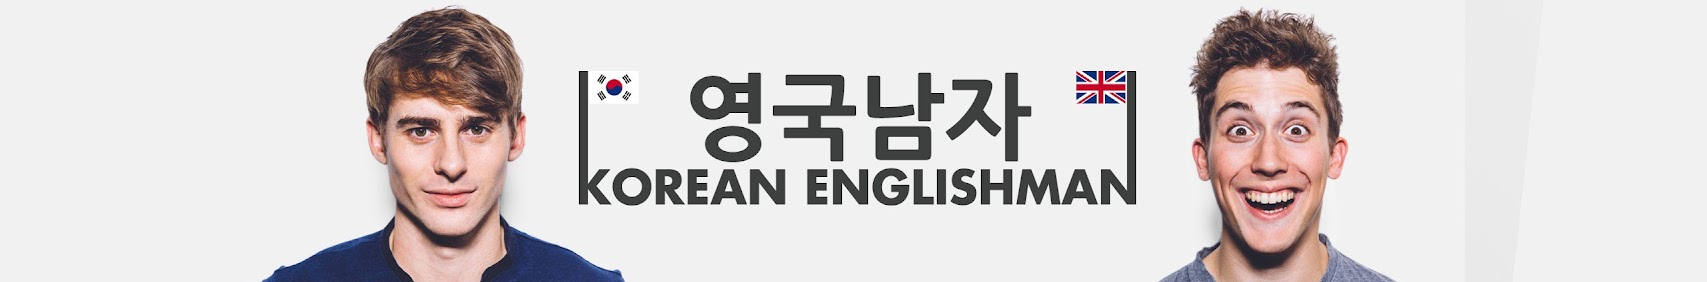

This project aims to analyze the performance and engagement metrics of the YouTube channel **Korean Englishman.** By examining various data points such as video views, likes, comments, and publication dates, we aim to uncover insights into what makes content successful on this popular channel. **The ultimate goal is to provide actionable recommendations for optimizing content strategy and increasing viewer engagement.**

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import re
import streamlit as st
from datetime import datetime
from googleapiclient.discovery import build
from googletrans import Translator
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy.stats import pearsonr, ttest_ind
from collections import Counter
import nltk
from nltk.corpus import stopwords

import warnings

warnings.filterwarnings("ignore")

## Import Data

In [3]:
kre_df = pd.read_csv('KoreanEnglishman-YoutubeData.csv')
kre_df.head(10)

,Video ID,Title,publishedAt,Duration,Views,Likes,Comments
0,nWua61rAJsE,British College Students try Korean Chicken BB...,2024-07-13T11:30:30Z,15:01,1518093,63440,1638.0
1,IfHA3zOE6dQ,British College Students get SHY in front of K...,2024-07-10T12:55:41Z,22:09,1679859,79970,3674.0
2,M0NRzhboz1I,British Uni Boys Call Home from Boot Camp!,2024-07-03T11:31:11Z,10:05,1252068,67131,2835.0
3,vF9x01la7k4,Korean Navy Officers Try British Rations for t...,2024-06-29T11:30:33Z,6:52,1291606,46217,1429.0
4,F8CRyMQbqY0,Korean Turtle Chips with Top ATP Tennis Players!,2024-06-27T13:00:22Z,0:51,137690,7390,93.0
5,6Bj2KEmNhVo,Korean Grape drinks with Top ATP Tennis Players!,2024-06-26T13:00:06Z,0:41,125457,6413,45.0
6,Qat8PGr4_gk,British Uni Students Try Korean Navy Rations f...,2024-06-26T11:30:21Z,10:41,1626074,62189,1724.0
7,5uBNCDzDyvg,ATP Tennis Players try Tteokbokki Snack!,2024-06-25T13:00:06Z,0:59,93520,5274,36.0
8,Xi05X2sraeo,ATP Tennis players try Korean Traditional Rice...,2024-06-24T13:00:35Z,0:55,123905,6549,61.0
9,avRKg_hjhIw,Top ATP Tennis Players try MILKIS for the Firs...,2024-06-23T13:00:02Z,0:50,128294,6339,59.0


In [4]:
kre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video ID     501 non-null    object 
 1   Title        501 non-null    object 
 2   publishedAt  501 non-null    object 
 3   Duration     501 non-null    object 
 4   Views        501 non-null    int64  
 5   Likes        501 non-null    int64  
 6   Comments     500 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 27.5+ KB


## Feature Engineering

In [5]:
# initiate translator
translator = Translator()

In [6]:
# translate Title from Korean to English
def translate_text(text, src='ko', dest='en'):
    try:
        return translator.translate(text, src=src, dest=dest).text
    except Exception as e:
        return text

kre_df['TranslatedTitle'] = kre_df['Title'].apply(lambda x: translate_text(x, src='ko', dest='en'))

In [7]:
kre_df['publishedAt'] = pd.to_datetime(kre_df['publishedAt']).dt.tz_localize(None)

In [8]:
kre_df['Duration'] = kre_df['Duration'].str.slice(0,5)

In [9]:
kre_df['Duration'] = pd.to_datetime(kre_df['Duration'], format='%M:%S')

In [10]:
# convert duration in seconds
kre_df['DurationSec'] = kre_df['Duration'].apply(lambda x: x.second + x.minute*60)

In [11]:
# divide the content types using the information of duration and video published date 
def content_type(row):
    # the maximum duration of Shorts is 60 and it was globally launced on July 2021
    if row['DurationSec'] <= 60 and row['publishedAt'] >= pd.Timestamp('2023-07-01'):
        return "Shorts"
    else:
        return "Longs"

In [12]:
# apply content_type function
kre_df['ContentType'] = kre_df.apply(content_type, axis=1)

In [13]:
# replace null comment with 0
kre_df['Comments'] = kre_df['Comments'].fillna(0)

In [14]:
# create engagement ratio
kre_df['EngageRatio'] = (kre_df['Likes'] + kre_df['Comments']) / kre_df['Views']

In [15]:
# we don't have much data on 2015 and below
kre_df = kre_df[kre_df['publishedAt'] > pd.Timestamp('2015-12-01')]

In [16]:
# extract the timestamp and round to the nearest hour
kre_df['publishedTime'] = kre_df['publishedAt'].dt.round('h').dt.time

In [17]:
# save the cleaned data
kre_df.to_csv('KoreanEnglishman-YoutubeData-Final.csv', index=False)

## Exploratory Data Analysis

In [18]:
# prepare all the titles to make Word cloud
text = ''.join(title for title in kre_df['TranslatedTitle'])
wordcloud = WordCloud(background_color='white',colormap='magma').generate(text)
# use nltk to exclude uncommon words in English and apply them to text
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
clean_text = re.sub(r'[!?+.]+', '', text)

[nltk_data] Downloading package stopwords to C:\Users\Azriel
[nltk_data]     Akbar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
words = clean_text.split()

In [20]:
filtered_words = [word for word in words if word.lower() not in stop_words]
# count the words
word_freq = Counter(filtered_words)

In [21]:
# extract the top 20 most common words that have been written
top_words = word_freq.most_common(20)
top_words = [(word.title(), count) for word, count in top_words]

In [22]:
for word, _ in top_words:
    kre_df[word] = kre_df['TranslatedTitle'].apply(lambda x: word.lower() in x.lower())

In [23]:
word_engagement = {}
for word, _ in top_words:
    word_df = kre_df[kre_df[word] == True]
    word_engagement[word] = word_df['EngageRatio'].mean()

In [24]:
word_engagement_df = pd.DataFrame(list(word_engagement.items()), columns=['Word', 'EngageRatio'])
word_engagement_df = word_engagement_df.sort_values(by='EngageRatio', ascending=False)

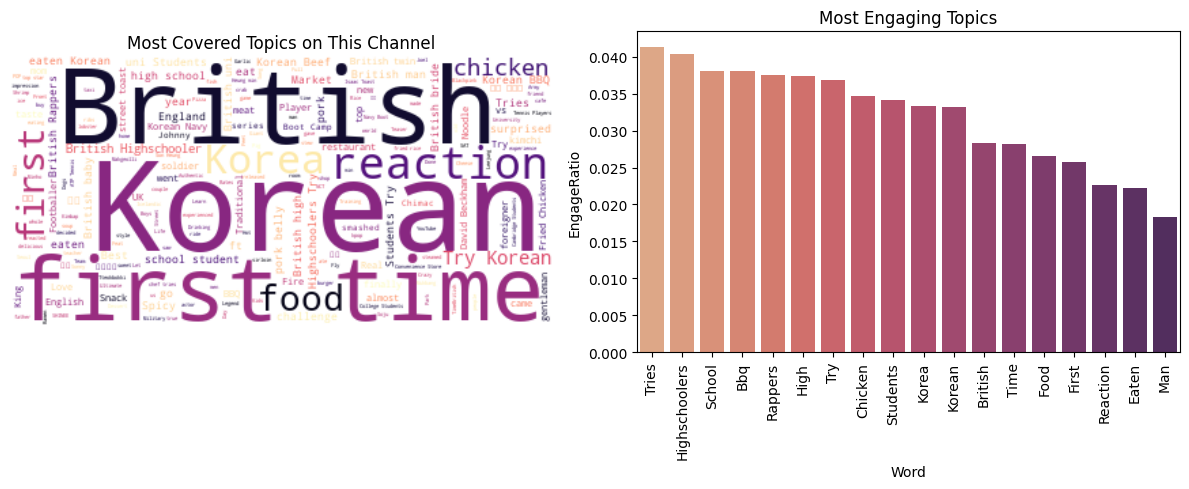

In [25]:
# create the word cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title("Most Covered Topics on This Channel")
ax1.axis('off')

# create a bar chart
sns.barplot(data=word_engagement_df, x='Word', y='EngageRatio', ax=ax2, palette='flare')
ax2.set_title('Most Engaging Topics')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In line with the goal to introduce Korean culture and food to the Englishman (영국남자), **the most common words** that have been written in the title were **first time, Korean, British, reaction, etc.**

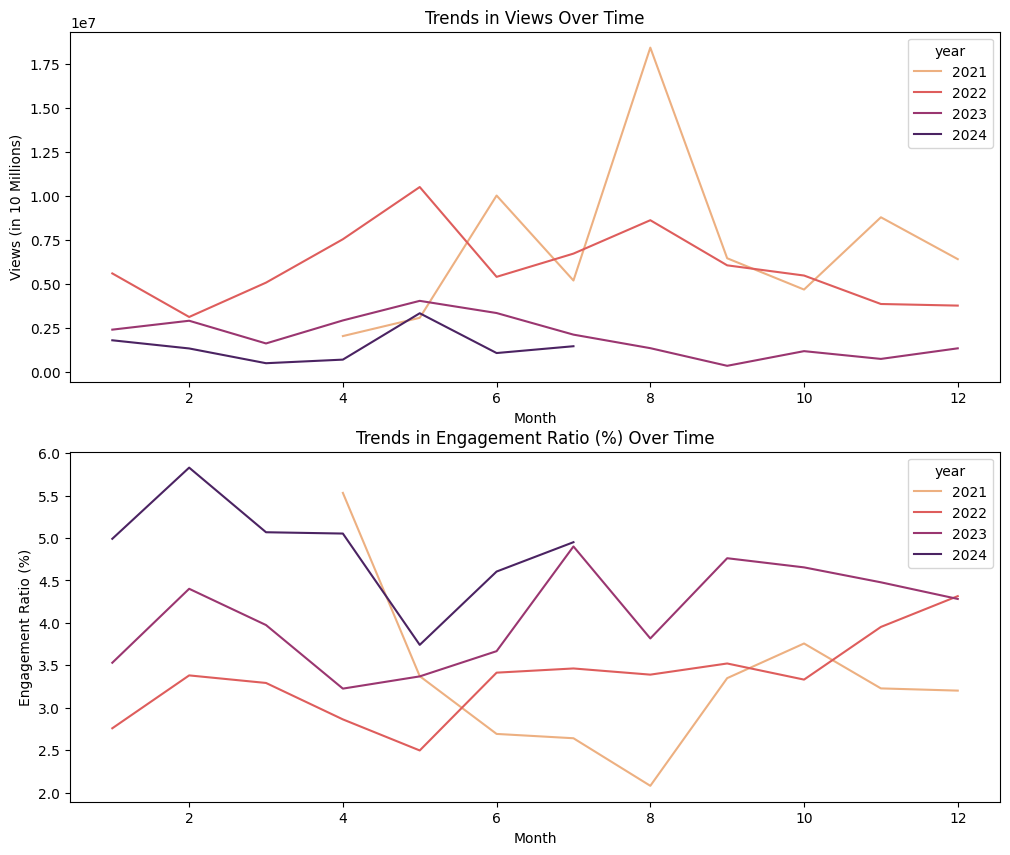

In [35]:
views_df = kre_df.query("publishedAt >= '2021-01-01'")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
sns.lineplot(data=views_df, x=views_df['publishedAt'].dt.month, y='Views',hue=views_df['publishedAt'].dt.year, errorbar=None, ax=ax1,palette='flare')
ax1.set_ylabel('Views (in 10 Millions)')
ax1.set_xlabel('Month')
ax1.legend(title='year')
ax1.set_title('Trends in Views Over Time')

views_df['month'] = views_df['publishedAt'].dt.month
views_df['year'] = views_df['publishedAt'].dt.year
views_df['EngageRatio'] = views_df['EngageRatio'] * 100
avg_engage_ratio = views_df.groupby(['year', 'month'])['EngageRatio'].mean().reset_index()
sns.lineplot(data=avg_engage_ratio, x='month', y='EngageRatio', hue='year', errorbar=None, palette='flare')
ax2.set_ylabel('Engagement Ratio (%)')
ax2.set_xlabel('Month')
ax2.set_title('Trends in Engagement Ratio (%) Over Time')

plt.show()

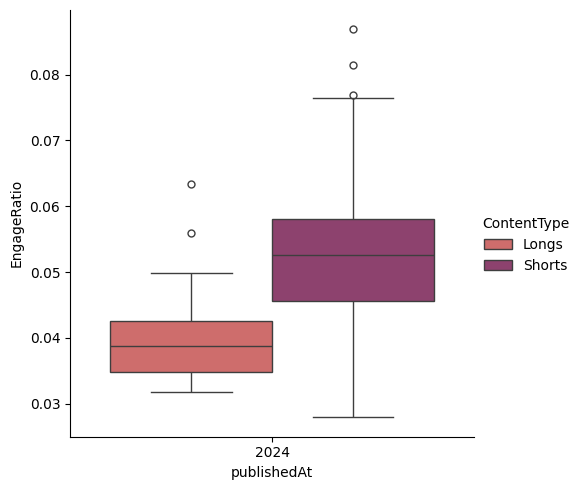

In [27]:
engage_df = kre_df.query("publishedAt >= '2023-12-31'")
sns.catplot(data=engage_df, x=engage_df['publishedAt'].dt.year, y='EngageRatio', hue='ContentType', kind='box', palette='flare')
plt.show()

In [66]:
# Hypothesis testing between groups of content type
longs_engage = kre_df[(kre_df['ContentType'] == 'Longs') & (kre_df['publishedAt'] > pd.Timestamp('2023-12-31'))]['EngageRatio']
shorts_engage = kre_df[(kre_df['ContentType'] == 'Shorts') & (kre_df['publishedAt'] > pd.Timestamp('2023-12-31'))]['EngageRatio']

# independent t-test
t_stat, p_value = ttest_ind(longs_engage, shorts_engage)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: -4.046494009480076, p-value: 0.0001226348845861901


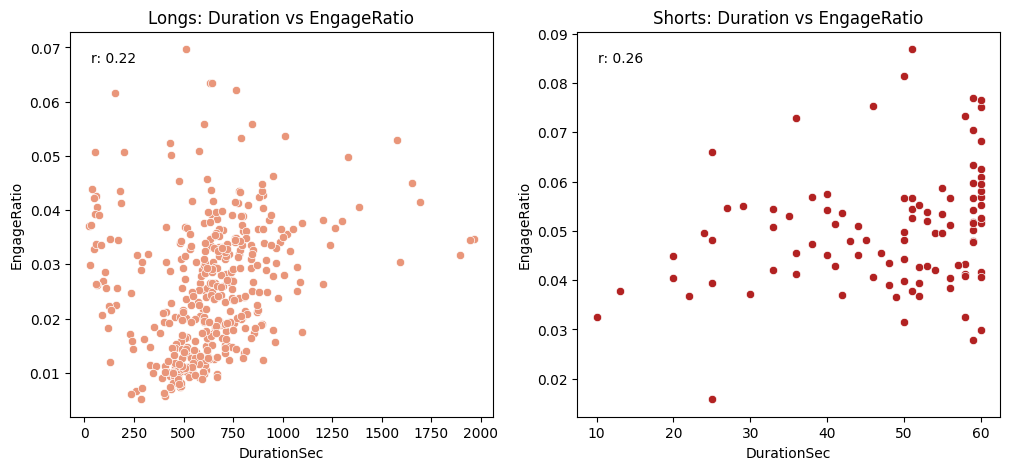

In [76]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=kre_df.query("ContentType == 'Longs'"), x='DurationSec', y='EngageRatio', color='darksalmon')
longs_df = kre_df.query("ContentType == 'Longs'")
corr_coef, p_value = pearsonr(longs_df['DurationSec'].dropna(), longs_df['EngageRatio'].dropna())
plt.text(0.05, 0.95, f'r: {corr_coef:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.title('Longs: Duration vs EngageRatio')

plt.subplot(1, 2, 2)
sns.scatterplot(data=kre_df.query("ContentType == 'Shorts'"), x='DurationSec', y='EngageRatio', color='firebrick')
shorts_df = kre_df.query("ContentType == 'Shorts'")
corr_coef, p_value = pearsonr(shorts_df['DurationSec'].dropna(), shorts_df['EngageRatio'].dropna())
plt.text(0.05, 0.95, f'r: {corr_coef:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.title('Shorts: Duration vs EngageRatio')

plt.show()

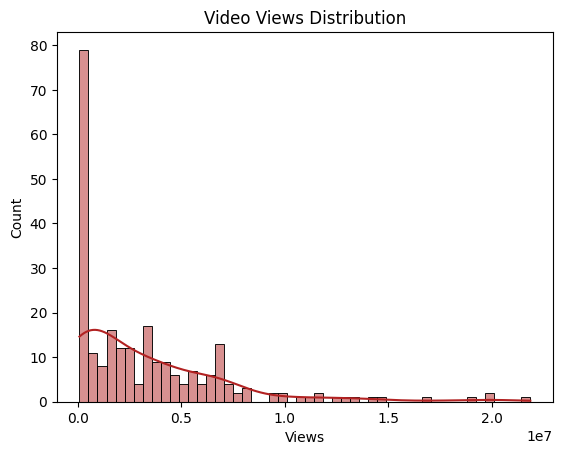

In [58]:
sns.histplot(x=views_df['Views'], bins=50, kde=True, color='firebrick')
plt.title('Video Views Distribution')
plt.show()

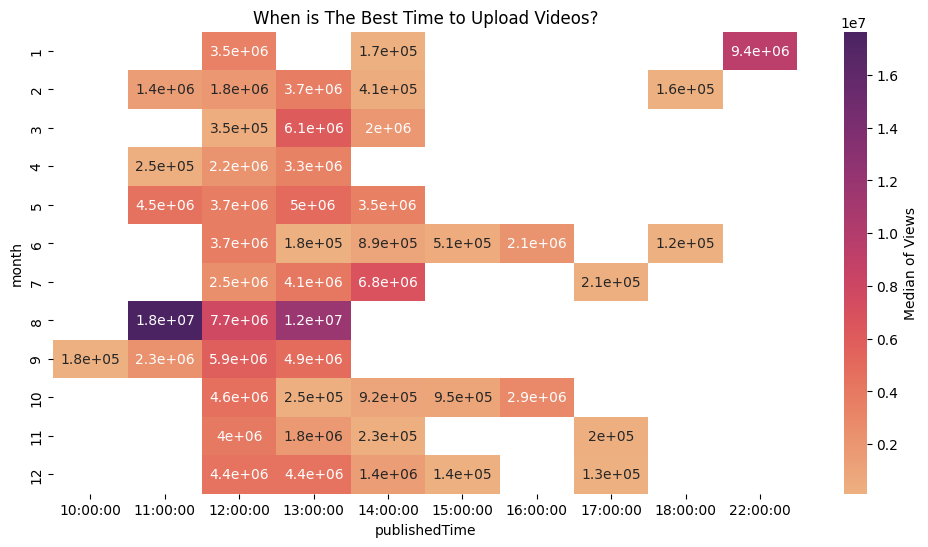

In [63]:
views_heatmap = views_df.pivot_table(index=['month'], columns='publishedTime',values='Views', aggfunc='median')
plt.figure(figsize=(12,6))
sns.heatmap(views_heatmap, cmap='flare', annot=True, cbar_kws={'label': 'Median of Views'})
plt.title('When is The Best Time to Upload Videos?')
plt.show()

In [77]:
df_agg_metrics_tosum = kre_df[['publishedAt', 'Views', 'Likes', 'Comments']]
df_agg_metrics_tomean = kre_df[['publishedAt', 'DurationSec', 'EngageRatio']]

metric_tosum = df_agg_metrics_tosum.sum(numeric_only=True)
metric_tomean = df_agg_metrics_tomean.mean(numeric_only=True)
metric_combined = pd.concat([metric_tosum, metric_tomean])

In [78]:
metric_combined

Views          1.820497e+09
Likes          4.396868e+07
Comments       1.785600e+06
DurationSec    5.147302e+02
EngageRatio    3.062760e-02
dtype: float64